# Expected Returns Timing
## 🎯 Learning Objectives

By the end of this notebook, you will be able to:

1. **Understand return predictability** — Why dividend yields might forecast future stock returns
2. **Run and interpret forecasting regressions** — Test if a signal predicts returns using proper inference
3. **Evaluate predictability out-of-sample** — Use R² comparisons and trading strategies
4. **Construct timing strategies** — Convert signals into portfolio weights
5. **Assess timing performance** — Use alpha, Sharpe ratios, and proper benchmarks

## 📋 Table of Contents

1. [Setup](#setup)
2. [The Predictability Puzzle](#predictability-puzzle)
3. [Dividend Yield as a Signal](#dividend-yield)
4. [Forecasting Regressions](#forecasting-regressions)
5. [Out-of-Sample Evaluation](#oos-evaluation)
6. [Trading Strategy Implementation](#trading-strategy)
7. [Performance Evaluation](#performance)
8. [Exercises](#exercises)
9. [Key Takeaways](#key-takeaways)

---

## 🛠️ Setup <a id="setup"></a>

In [1]:
#@title 🛠️ Setup: Run this cell first (click to expand)

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# statsmodels: Statistical modeling for Python
# Provides OLS regression with robust standard errors (HAC)
!pip install statsmodels
import statsmodels.api as sm

# pandas-datareader: Fetches financial data from online sources
from pandas_datareader import data as DataReader

# Set consistent plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
#@title Helper Function: Get Factor Data

def get_factors(factors='CAPM', freq='daily'):
    """
    Fetch Fama-French factor data from Ken French's website.

    Parameters:
    -----------
    factors : str
        'CAPM' (RF, Mkt-RF), 'FF3', 'FF5', or 'FF6'
    freq : str
        'daily' or 'monthly'
    """
    freq_label = '' if freq == 'monthly' else '_' + freq

    if factors == 'CAPM':
        ff = DataReader.DataReader(f"F-F_Research_Data_Factors{freq_label}",
                                   "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF']]
    else:
        ff = DataReader.DataReader(f"F-F_Research_Data_Factors{freq_label}",
                                   "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF', 'SMB', 'HML']]

    if freq == 'monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp() + pd.offsets.MonthEnd(0))
    else:
        df_factor.index = pd.to_datetime(df_factor.index)

    return df_factor / 100

---

## The Predictability Puzzle <a id="predictability-puzzle"></a>

### The Classic Finding

One of the most famous findings in finance:

**High dividend yield periods are followed by above-average returns**

![Dividend Yield and Future Returns](https://github.com/amoreira2/Fin418/blob/main/assets/plots/Timing1.jpg?raw=1)

This finding earned Robert Shiller a Nobel Prize! 🏆

### Why is This Surprising?

When prices are low (relative to dividends), you might expect:
- ❌ Future dividends will fall → "Bad news is priced in"

But what actually happens:
- ✅ Future **prices go up** → Expected returns were high!

This suggests **expected returns vary over time**.

Intution is super general but you can see it in the simple Gordon growth formula

$$P=\frac{D}{r-g}$$

Implies

$$\frac{D}{P}=r-g$$

So if dividend yield is low is either becasue

- Expected returns are low or expected growth is high

> **💡 Key Insight:**
>
> If expected returns are time-varying and predictable, you can build
> **timing strategies** that invest more when expected returns are high.

---

## Dividend Yield as a Signal <a id="dividend-yield"></a>

### Loading Market Data

In [3]:
# Load CRSP market data with dividend yield
url = 'https://raw.githubusercontent.com/amoreira2/UG54/refs/heads/main/assets/data/Markettiming_data1.csv'
crsp = pd.read_csv(url, parse_dates=['date'], index_col='date')

print(f"Data range: {crsp.index.min().date()} to {crsp.index.max().date()}")
crsp.head()

Data range: 1925-12-31 to 2024-12-31


,vwretd,vwretx,dp
date,,,
1925-12-31,NaN,NaN,NaN
1926-01-30,0.000561,-0.001395,0.001959
1926-02-27,-0.033046,-0.036587,0.003675
1926-03-31,-0.064002,-0.070021,0.006472
1926-04-30,0.037029,0.034043,0.002888


The data contains:
- `vwretd`: Value-weighted market return (with dividends)
- `vwretx`: Value-weighted market return (without dividends)
- `dp`: Dividend yield (dividend/price ratio)

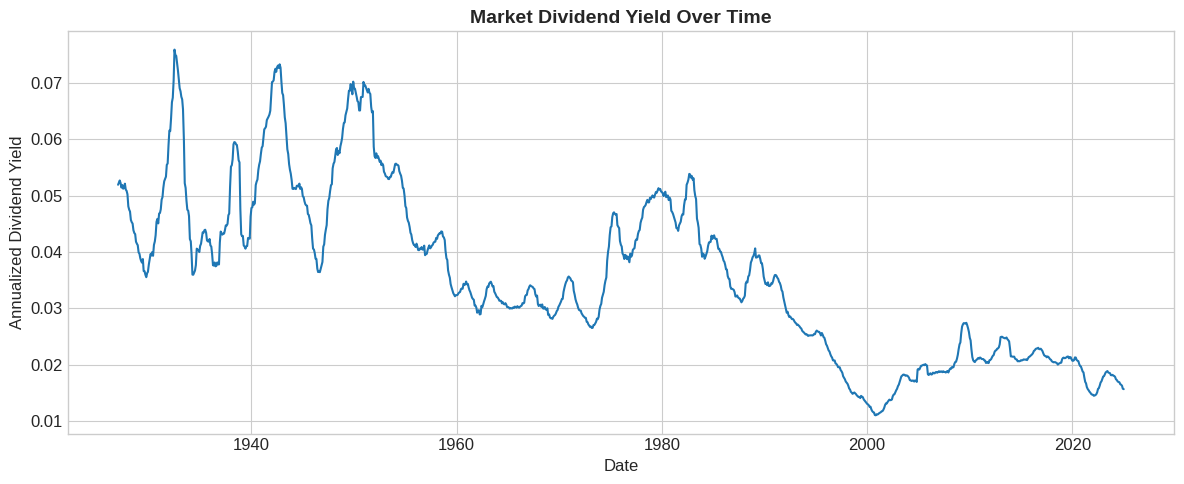

In [4]:
# Plot annualized dividend yield (smoothed over 12 months)
fig, ax = plt.subplots(figsize=(12, 5))

dp_annual = crsp['dp'].rolling(window=12).mean() * 12
ax.plot(dp_annual, linewidth=1.5)

ax.set_xlabel('Date')
ax.set_ylabel('Annualized Dividend Yield')
ax.set_title('Market Dividend Yield Over Time', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

> **📌 Remember:**
>
> - Dividend yields ranged from 4-7% in the 1930s to around 2% today.
> - This secular decline is important for interpretation.
> - Why ? In english what that means?

> **🤔 Think:**
>
> 1. Why might high dividend yields predict high future returns?
> 2. Why might dividend yields NOT predict returns?

---

## Forecasting Regressions <a id="forecasting-regressions"></a>

### The Forecasting Framework

To test if a signal predicts returns, run:

$$r_{t \rightarrow t+h} = a + b \cdot \text{signal}_t + u_{t+h}$$

Key differences from factor models:
- Relationship is **not contemporaneous**
- We **know the signal ahead of time**
- We're predicting returns over horizon $h$

### Preparing the Data

In [23]:
# Get risk-free rate
df_factors = get_factors('CAPM', freq='monthly').dropna()

# Align indices
crsp.index = crsp.index + pd.offsets.MonthEnd(0)

# Merge with factors
merged = crsp.merge(df_factors[['RF']], left_index=True, right_index=True)

# Parameters
years = 5  # Forecast horizon

# Compute future 5-year returns (annualized)
merged['R_future'] = (
    (1 + merged['vwretd'])
    .rolling(window=years * 12)
    .apply(np.prod)
    .shift(-years * 12) ** (1/years) - 1
)

# Smooth dividend yield (annualized)
merged['dp_avg'] = merged['dp'].rolling(window=12).mean() * 12

print(f"Correlation: {merged['dp_avg'].corr(merged['R_future']):.3f}")

Correlation: 0.357


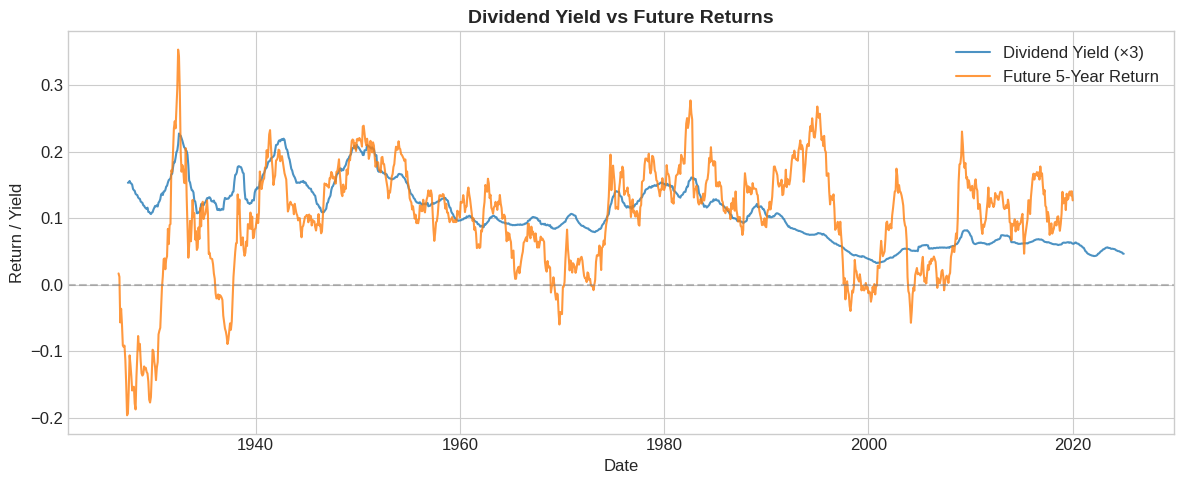

In [24]:
# Visualize the relationship
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(merged.index, merged['dp_avg'] * 3, label='Dividend Yield (×3)', alpha=0.8)
ax.plot(merged.index, merged['R_future'], label='Future 5-Year Return', alpha=0.8)

ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Return / Yield')
ax.set_title('Dividend Yield vs Future Returns', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

### Running the Regression

In [25]:
# Naive OLS regression
X = sm.add_constant(merged['dp_avg'])
model_naive = sm.OLS(merged['R_future'], X, missing='drop').fit()
print(model_naive.summary())

                            OLS Regression Results                            
Dep. Variable:               R_future   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     161.8
Date:                Mon, 19 Jan 2026   Prob (F-statistic):           1.08e-34
Time:                        18:50:41   Log-Likelihood:                 1299.2
No. Observations:                1111   AIC:                            -2594.
Df Residuals:                    1109   BIC:                            -2584.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0297      0.006      4.878      0.0

> **⚠️ Caution:**
>
> Look at that t-statistic! Seems too good to be true...
>
> The problem: **overlapping windows** inflate the t-statistic.
> With 5-year returns, consecutive observations share 59 out of 60 months!

### Correcting for Overlapping Returns

In [26]:
# HAC standard errors (Newey-West) to correct for overlap
model_hac = sm.OLS(merged['R_future'], X, missing='drop').fit(
    cov_type='HAC',
    cov_kwds={'maxlags': years * 12}
)
print(model_hac.summary())

                            OLS Regression Results                            
Dep. Variable:               R_future   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     11.89
Date:                Mon, 19 Jan 2026   Prob (F-statistic):           0.000584
Time:                        18:50:46   Log-Likelihood:                 1299.2
No. Observations:                1111   AIC:                            -2594.
Df Residuals:                    1109   BIC:                            -2584.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0297      0.024      1.232      0.2

> **💡 Key Insight:**
>
> After correcting for overlap, the t-statistic drops substantially.
> The relationship may still be significant, but with much more uncertainty.

---

## Out-of-Sample Evaluation <a id="oos-evaluation"></a>

### Why Out-of-Sample Matters

- We can't trade on data we haven't seen yet
- Relationships may be spurious or unstable

There are many ways of conducting an out of sample analysis. And there is a lot of science to it

For now we will keep it simple and split in an arbitrary date

<Axes: >

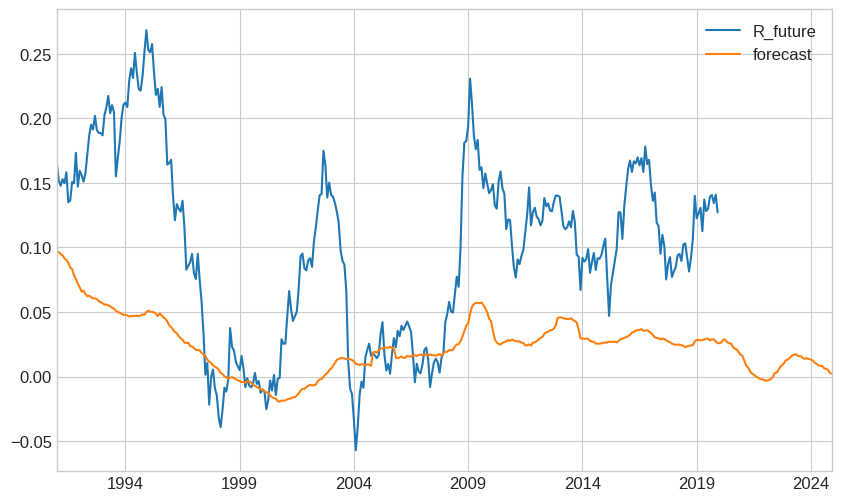

In [27]:
# Split into estimation and test samples
estimation = merged['1950':'1990'].copy()
test = merged['1991':].copy()

# Estimate model on estimation sample
X_est = sm.add_constant(estimation['dp_avg'])
model_est = sm.OLS(estimation['R_future'], X_est, missing='drop').fit(
    cov_type='HAC',
    cov_kwds={'maxlags': years * 12}
)

# Generate forecasts for test sample USING THE ESTIMATED PARAMETERS IN ESTIMATION SAMPLE
test['forecast'] = model_est.params['const'] + model_est.params['dp_avg'] * test['dp_avg']

test[['R_future','forecast']].plot()

### What is going wrong?

- Structural breaks in dividend policy? Firms now returns capital usign buy-backs
- Maybe there was a one of reduction in risk-premia and now yields mean-revert around a different average?
- but timing the market is very hard
- good news is that you can easily test if any suggestion people give makes sense, e.g.  Does "Buy the Dip" works?



How to fomally evaluate if it is working?

1. Form the trading strategy and look at the returns

2. Out of Sample R-squared

---

## Trading Strategy Implementation <a id="trading-strategy"></a>

### From Signal to Weights

The optimal weight on the market is:

$$x_t = \frac{\mu_t}{\gamma \sigma^2} = \frac{a + b \cdot \text{DP}_t}{\gamma \sigma^2}$$

where:
- $\mu_t = a + b \cdot \text{DP}_t$ is the forecasted premium
- $\gamma$ is risk aversion
- $\sigma$ is volatility (assumed constant for now)

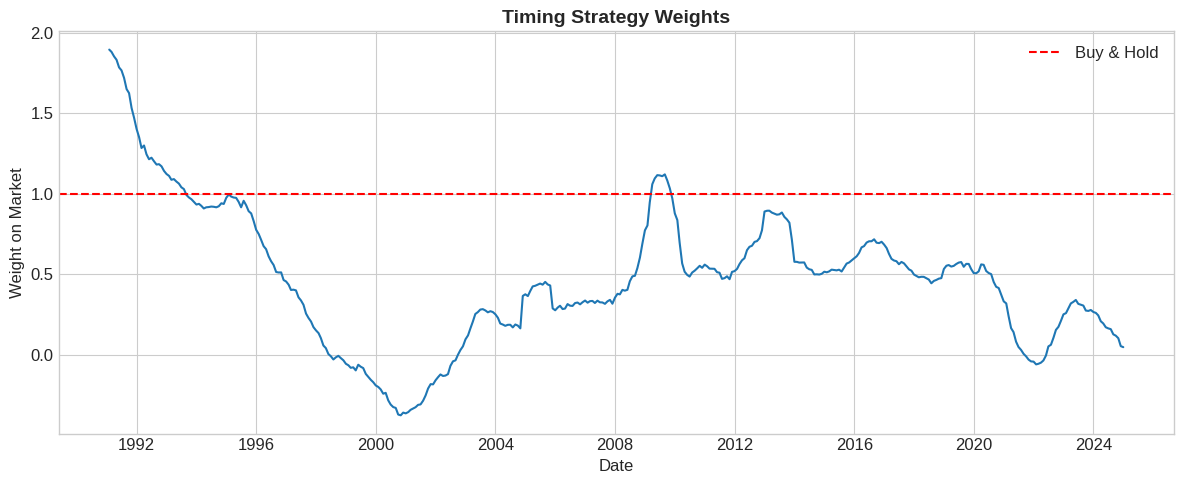

In [28]:
# Strategy parameters
gamma = 2
vol = 0.16  # Annual volatility

# Compute weights
test['weight'] = test['forecast'] / (gamma * vol**2)

# Visualize weights
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(test.index, test['weight'], linewidth=1.5)
ax.axhline(1, color='red', linestyle='--', label='Buy & Hold')

ax.set_xlabel('Date')
ax.set_ylabel('Weight on Market')
ax.set_title('Timing Strategy Weights', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

### Strategy Returns

The timing strategy return is:

$$r^{\text{timing}}_{t+1} = r^f_{t+1} + x_t (r^{\text{mkt}}_{t+1} - r^f_{t+1})$$

In [17]:
test

,vwretd,vwretx,dp,RF_x,R_future,dp_avg,forecast,weight,RF_y
1991-01-31,0.049083,0.046987,0.002002,0.0052,0.117732,0.035899,0.039267,0.766928,0.0052
1991-02-28,0.075848,0.071836,0.003743,0.0048,0.105225,0.035742,0.038513,0.752212,0.0048
1991-03-31,0.028922,0.026702,0.002162,0.0044,0.101422,0.035436,0.037044,0.723525,0.0044
1991-04-30,0.003311,0.001186,0.002122,0.0053,0.106441,0.035207,0.035950,0.702141,0.0053
1991-05-31,0.040737,0.037177,0.003432,0.0047,0.103558,0.034687,0.033456,0.653443,0.0047
...,...,...,...,...,...,...,...,...,...
2024-08-31,0.021572,0.020203,0.001342,0.0048,NaN,0.016496,-0.053761,-1.050016,0.0048
2024-09-30,0.020969,0.019485,0.001456,0.0040,NaN,0.016407,-0.054187,-1.058334,0.0040
2024-10-31,-0.008298,-0.009139,0.000849,0.0039,NaN,0.016233,-0.055020,-1.074606,0.0039
2024-11-30,0.064855,0.063463,0.001309,0.0040,NaN,0.015693,-0.057611,-1.125224,0.0040


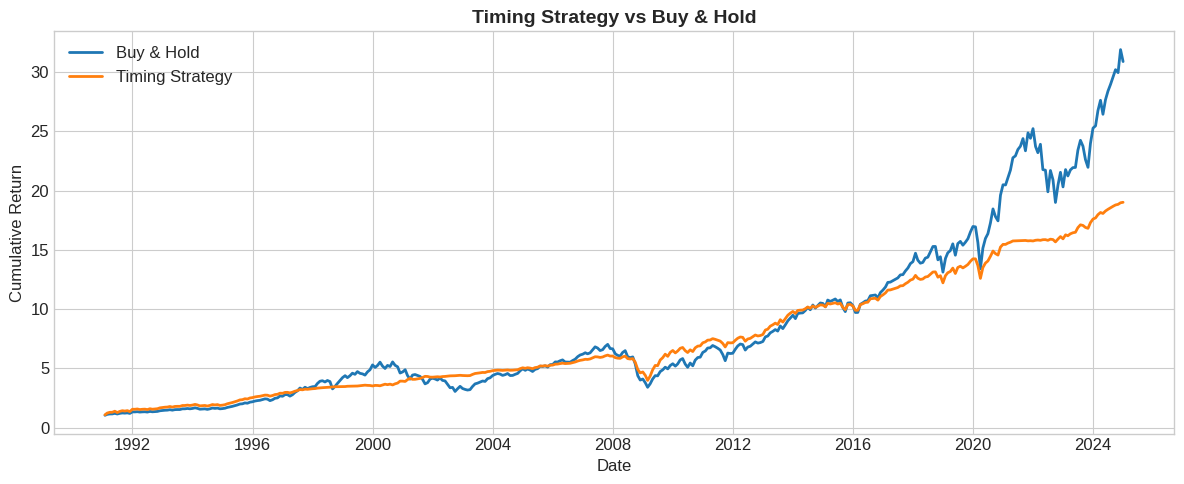

In [29]:
# Merge with factors to get RF


# Compute strategy returns
test['ret_timing'] = test['RF'] + test['weight'] * (test['vwretd'] - test['RF'])

# Cumulative returns
fig, ax = plt.subplots(figsize=(12, 5))

cum_timing = (1 + test['ret_timing']).cumprod()
cum_mkt = (1 + test['vwretd']).cumprod()

ax.plot(test.index, cum_mkt, label='Buy & Hold', linewidth=2)
ax.plot(test.index, cum_timing, label='Timing Strategy', linewidth=2)

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Timing Strategy vs Buy & Hold', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

---

## Performance Evaluation <a id="performance"></a>

How to evaluate if we "beat the market"?

Is looking at the raw cumulative return enough?

What differences we might want to account for?

### Sharpe Ratio Comparison

In [30]:
# Compute Sharpe ratios
excess_timing = test['ret_timing'] - test['RF']
excess_mkt = test['vwretd'] - test['RF']

sr_timing = (excess_timing.mean() * 12) / (excess_timing.std() * np.sqrt(12))
sr_mkt = (excess_mkt.mean() * 12) / (excess_mkt.std() * np.sqrt(12))

print(f"Sharpe Ratio (Timing):     {sr_timing:.3f}")
print(f"Sharpe Ratio (Buy & Hold): {sr_mkt:.3f}")

Sharpe Ratio (Timing):     0.748
Sharpe Ratio (Buy & Hold): 0.581


> **💡 Key Insight:**
>
> To the extent timing works, you harvest more premium per unit of risk.
> If beta just varies but timing doesn't add value, Sharpe ratios will be similar or even go down if you are jsut adding noise to your trading strategy

It has a higher Sharpe out of sample

- Can we exploit this fact to obtain construct a strategy that dominates buy and hold? How?
- Alternatively, can we adjust the buy and hold benchmark so we are comparing apples with apples?



### Out of Sample R-squared


One thing that people do to evaluate these forecasting regressions is look at the R-squared **out of sample** relative to some benchmark prediction for the expected returns.

- Typically a regression R-squared has the sample average

$$R^2_{Standard}=1-\frac{\sum(r_{t+1}-(a+b *signal_t))^2}{\sum(r_{t+1}-Average(r_{t+1}))^2}$$

- You compare the model explanatory power, i.e. reduction in $\sum(r_{t+1}-(a+b *signal_t))^2$, with the reduction in simply subtracting the sample average $\sum(r_{t+1}-Average(r_{t+1}))^2$

- But we need a bechmark that also cannot see the future--knowign the future average would be amazing right?

- what people do is to use the estimation sample average--instead of using the signal--just use past average returns

$$R^2_{OOS}=1-\frac{\sum(r_{t+1}-(a+b *signal_t))^2}{\sum(r_{t+1}-r_{past average})^2}$$





In [34]:

r_past_average=(estimation['R_future']).mean()

R2_TS=1-((test['R_future']-(test['forecast']))**2).sum()/((test['R_future']-r_past_average)**2).sum()
R2_TS

np.float64(-0.6026909813375205)

- How to interpret this negative number?

---

## Exercises <a id="exercises"></a>

### 🔧 Exercise 1: Overlapping Returns Problem

Explain why overlapping returns cause problems for standard errors.

1. If we use 5-year returns, how many months overlap between consecutive observations?
2. What does this do to the effective sample size?
3. How does HAC correction help?

<details>
<summary>💡 Click for solution</summary>

1. With 60-month returns, consecutive observations share 59 months of data.

2. The effective sample size is much smaller than the raw count. If we have 100 years of monthly data (1200 months), we don't have 1200 independent observations—we have closer to 20 (100/5).

3. HAC (Heteroskedasticity and Autocorrelation Consistent) standard errors account for the serial correlation induced by overlapping windows, giving us proper inference.

</details>

### 🔧 Exercise 2: Alternative Signals

Explain the economic intuition for why each signal might predict market returns:

1. **Credit spread** (BBB yield - Treasury yield)
2. **VIX** (implied volatility index)
3. **Aggregate short interest** (fraction of market cap in short positions)

<details>
<summary>💡 Click for solution</summary>

1. **Credit spread**: High spreads indicate economic stress and high risk premia. Investors demand more compensation → expect higher future returns.

2. **VIX**: High implied volatility may indicate high risk premia (though volatility itself doesn't predict returns well). The variance risk premium (VIX² - RV) is a better predictor.

3. **Short interest**: High short interest may indicate overvaluation or pessimism. If shorts are informed, this predicts lower returns. If it's excessive pessimism, it could mean mean-reversion (higher returns).

</details>

In [ ]:
# Your code here

### 🤔 Exercise 3: Break the Sample

Using the test sample data:

1. Split it into two sub-periods of similar size
2. Compute Sharpe ratios for timing vs buy-and-hold in each sub-period
3. Are the results stable across periods?

<details>
<summary>💡 Click for solution</summary>

```python
# Split test sample
period1 = test['2011':'2017']
period2 = test['2018':]

for name, df in [('2011-2017', period1), ('2018-2024', period2)]:
    sr_t = (df['ret_timing'] - df['RF']).mean() * 12 / ((df['ret_timing'] - df['RF']).std() * np.sqrt(12))
    sr_m = (df['vwretd'] - df['RF']).mean() * 12 / ((df['vwretd'] - df['RF']).std() * np.sqrt(12))
    print(f"{name}: Timing SR = {sr_t:.3f}, Market SR = {sr_m:.3f}")
```

Results often vary significantly across periods, highlighting the instability of return predictability.

</details>

In [ ]:
# Your code here

---

## 📝 Key Takeaways <a id="key-takeaways"></a>

- **To time a factor, you need a signal that predicts future returns.** Dividend yield is the classic example, but many others exist.

- **In-sample predictability is just the start.** The relationship must be stable enough to work out-of-sample.

- **Overlapping returns require special care.** Use HAC standard errors or non-overlapping samples for proper inference.

- **Evaluate with out-of-sample R² or trading strategies.** Use the historical average as your benchmark.

- **The right benchmark has the same average beta.** Regress timing returns on the factor and look at alpha.

- **Dividend yield predictability is weak and unstable.** The signal is so persistent that even long samples have few independent observations.

- **Sharpe ratios isolate timing skill.** Pure beta variation is SR-neutral; only alpha improves the Sharpe ratio.